# TP3
### Équipe 10
### Fabrice Charbonneau (1798064)
### Sanou Armel Kenzanga Landry (1976804)


1. créer une matrice termes-documents; pour diminuer la taille du vocabulaire, utiliser un stemmer et éliminer les chiffres et la ponctuation;
2. transformer les fréquences brutes par les valeurs TF-IDF;
3. effectuer une réduction de dimensions avec SVD; utilisez 50 dimensions latentes.



D'abord, lire les fichiers et les ajouter à un dataframe.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import PlaintextCorpusReader
from os import path

#can be removed
from jupyterthemes import jtplot
jtplot.style()

In [2]:
if not path.exists("raw_data.csv"):
    i = 0
    df = pd.DataFrame(columns=['uni', 'course', 'text'])
    class_data = 'Descriptions' 
    corpus = PlaintextCorpusReader(class_data, '.*txt', encoding='latin-1')
    for file in corpus.fileids():
        uni_str = file.split("/")[0]
        new_corpus = PlaintextCorpusReader(class_data, file, encoding='latin-1')
        df.loc[i] = [uni_str, file.split("/")[1].split(".")[0], new_corpus.raw()]
        i += 1
        print(i,  end='\r')
    df.to_csv("raw_data.csv", index=False)

In [3]:
df = pd.read_csv("raw_data.csv")

Détection du langage des textes avec https://pypi.org/project/langdetect/

Nous n'allons conserver que les cours ayant comme langage détecté le français.

In [4]:
from langdetect import detect

if not path.exists("fr_only.csv"):
    df["lang"] = df.apply( lambda row: detect(row["text"]), axis=1)
    df = df[df["lang"] == "fr"]
    df.to_csv("fr_only.csv", index=False)
df = pd.read_csv("fr_only.csv")

In [5]:
df = df.drop(columns="lang")

In [6]:
df

,Unnamed: 0,uni,course,text
0,0,HEC,1-404-96,TitreCours: Sociologie de l\nDescriptionCours:...
1,1,HEC,1-407-00,TitreCours: Management\nDescriptionCours: Ce c...
2,3,HEC,1-611-09,TitreCours: Modelisation et optimisation\nDesc...
3,4,HEC,1-611-96,TitreCours: Modelisation et optimisation\nDesc...
4,5,HEC,1-612-96,TitreCours: Mathematiques financieres\nDescrip...
...,...,...,...,...
16050,16330,UdM,VNM1060H,TitreCours: Vietnamien elementaire 2\nDescript...
16051,16331,UdM,VNM2050,TitreCours: Vietnamien intermediaire 1\nDescri...
16052,16332,UdM,VNM2050H,TitreCours: Vietnamien intermediaire 1\nDescri...
16053,16333,UdM,VNM2060,TitreCours: Vietnamien intermediaire 2\nDescri...


Utilisation d'un Tokenizer pour séparer les strings en mots.

TweetTokenizer de nltk est à la base fait pour les tweets, donc traite le texte pouvant contenir des hashtags et autres particularité des tweets. Dans notre cas, ça ne change pas grand chose, il fera facilement le travail même le texte n'est pas des tweets.

In [7]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
tokens = df["text"].apply(lambda x: tknzr.tokenize(x)).values

Stemmer afin d'éliminer les tokens inutles

In [8]:
from nltk.stem.snowball import SnowballStemmer
import string
from nltk.corpus import stopwords

In [9]:
st = SnowballStemmer("french", ignore_stopwords=True)
[st.stem(word) for word in ["Yeux", "Sociologie", ".", "souris"]]

['yeux', 'sociolog', '.', 'sour']

In [10]:
class Preprocessor:
    def __init__(self, stem=True, punctuation=True, digit=True):
        self.st = SnowballStemmer("french", ignore_stopwords=True)
        self.punctuations = set(string.punctuation)
        self.stem = stem
        self.punctuation = punctuation
        self.digit = digit
    
    def raw_preprocess(self, token_list):
        new_token_list = []
        for token in token_list:
            is_token_valid = True
            token = token.lower()
            
            # stemming
            if self.stem:
                token = self.st.stem(token)

            # punctuation filtering
            if self.punctuation and token in self.punctuations:
                is_token_valid = False

            # digit filtering
            elif self.digit and token.isdigit():
                is_token_valid = False

            # add token to new sub list
            if is_token_valid:
                new_token_list.append(token)
        return new_token_list
        
    def preprocess_tokens(self, tokens):
        new_tokens = []
        for token_list in tokens:
            new_tokens.append(self.raw_preprocess(token_list))
        return new_tokens
    
def preprocess(tokens):
    preprocessor = Preprocessor()
    return preprocessor.preprocess_tokens(test)

In [11]:
test = [
    ['Sociologie', 'de', 'l', 'DescriptionCours', ':', 'Trois', 'volets', 'principaux', 'dans', 'ce', 'cours'],
    ['Management', 'DescriptionCours', ':', 'Ce', 'cours', 'est', 'une', 'introduction', 'au', 'management', 'et']
]
preprocessor = Preprocessor()
preproc_test = preprocessor.preprocess_tokens(test)
preproc_test

[['sociolog',
  'de',
  'l',
  'descriptioncour',
  'trois',
  'volet',
  'principal',
  'dans',
  'ce',
  'cour'],
 ['manag',
  'descriptioncour',
  'ce',
  'cour',
  'est',
  'une',
  'introduct',
  'au',
  'manag',
  'et']]

TF-IDF

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(preprocessor=preprocessor.raw_preprocess ,tokenizer=identity_tokenizer)
#vectorizer = TfidfVectorizer(preprocessor=preprocessor.raw_preprocess)
IDF_data = vectorizer.fit_transform(tokens)

In [13]:
IDF_data

<16055x21286 sparse matrix of type '<class 'numpy.float64'>'
	with 713904 stored elements in Compressed Sparse Row format>

SVD

In [14]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, algorithm='randomized', n_iter=100)
svd.fit(IDF_data)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=100,
             random_state=None, tol=0.0)

In [15]:
sum(svd.explained_variance_)

0.1837329351690285

In [16]:
SVD_data = svd.transform(IDF_data)

## 1. Quels sont les 10 cours les plus similaires à LOG2420 dans l'espace réduit à 50 dimensions? (8 pts.) Prenez le cosinus comme mesure de similarité. 

In [17]:
LOG2420_idx = df.index[df["course"] == 'LOG2420'][0]

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(SVD_data)

In [76]:
log_2420_cos = cos_matrix[LOG2420_idx]
log_2420_sorted_cos = np.sort(log_2420_cos)

In [77]:
recommendations_cos = log_2420_sorted_cos[::-1][1:11] #[::-1] reverses the list, and [1:11] takes the 10 firsts ignoring the very first one which is the course itself

In [78]:
recommendations_indexes = [np.where(log_2420_cos == reco)[0][0] for reco in recommendations_cos]

In [79]:
df.loc[list(recommendations_indexes)]

,Unnamed: 0,uni,course,text
1669,1888,Poly,LOG1000,TitreCours: Ingenierie logicielle\nDescription...
1585,1804,Poly,INF1005C,TitreCours: Programmation procedurale\nDescrip...
1584,1803,Poly,INF1005B,TitreCours: Programmation procedurale\nDescrip...
1583,1802,Poly,INF1005A,TitreCours: Programmation procedurale\nDescrip...
1660,1879,Poly,INF8701,TitreCours: Simulation des systemes a evenem. ...
967,1186,Poly,AE4500,TitreCours: Informatique embarque\nDescription...
1670,1889,Poly,LOG2410,TitreCours: Conception logicielle\nDescription...
1682,1901,Poly,LOG4430,TitreCours: Architecture logicielle et concept...
1552,1771,Poly,IND6402,TitreCours: Interfaces humains-ordinateurs\nDe...
1658,1877,Poly,INF8500,TitreCours: Systemes embarques:conception et v...


On peut voir que les calculs semblent fonctionner. Les cours recommandés sont tous des cours en rapport au logiciel et à l'informatique, et sont tous à polytechnique. Cela confirme que l'approche focntionne correctment.

## 2. Effectuez une classification de cours par une approche supervisée (4 pts.) Pour établir les libellés de classes, prenez les acronymes de cours commençant par PSY (psychologie) et PHY (physique). Calculez les centroides de chaque classe (PSY et PHY) des données d'entraînement et calculez l'aire sous la courbe ROC pour la prédiction de données de test (AUC, Area Under receiver operator Curve). 

Ajout d'une colonne au dataframe permettant de déterminer si un cours est un cours de physique (PHY) ou un cours de psychologie (PSY).

In [22]:
mask = ((df["course"].astype(str).str[:3] == "PSY") | (df["course"].astype(str).str[:3] == "PHY"))
class_df = df[mask]

class_df["PSY"] = df["course"].astype(str).str[:3] == "PSY"
class_df

/home/fabrice/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Unnamed: 0,uni,course,text,PSY
7633,7891,UQAM,PHY0350,TitreCours: Introduction a la mecanique genera...,False
7634,7892,UQAM,PHY1011,TitreCours: L\nDescriptionCours: Ce cours s'ad...,False
7635,7893,UQAM,PHY1020,TitreCours: Les systemes physiques\nDescriptio...,False
7636,7894,UQAM,PHY1030,TitreCours: La physique des interactions et de...,False
7637,7895,UQAM,PHY1050,TitreCours: Mecanique\nDescriptionCours: Ce co...,False
...,...,...,...,...,...
15102,15379,UdM,PSY3299,TitreCours: Stage d'initiation a la psychologi...,True
15103,15380,UdM,PSY3952,TitreCours: Psychologie en readaptation\nDescr...,True
15104,15381,UdM,PSY3954,TitreCours: Methodes d'entrevue en sante\nDesc...,True
15105,15382,UdM,PSY4000,TitreCours: Projet de recherche Honor\nDescrip...,True


L'étape suivante permet de récupérer les données qui correspondent aux cours PHY et PSY. Cette fonction sera utilisée plus tard afin d'obtenir facilement les données voulues selon le type de données (tokens, IDF, SVD, ...) d'une matrice contenant l'ensemble du jeu de données (tous les cours).


In [23]:
PHY_PSY_indexes = list(class_df.index.values)

In [24]:
def retrieve_PHY_PSY(full_data):
    PHY_PSY_data = []
    for index in PHY_PSY_indexes:
        PHY_PSY_data.append(full_data[index])
    return  np.array(PHY_PSY_data)

In [25]:
X_data = retrieve_PHY_PSY(SVD_data)

In [26]:
y_data = class_df["PSY"].values

In [27]:
len(X_data)

521

In [28]:
len(y_data)

521

In [29]:
n_positives = 0
for y in y_data:
    if y:
        n_positives += 1
n_positives

407

Il est intéressant de noter que 407 sur 521 des cours sont des cours de psychologie, représentant près de 80% du sous-ensemble de cours.

In [30]:
# proportion de cours de psychologie
n_positives/len(y_data)

0.781190019193858

Maintenant que l'on a les données correctement organisées avec `X_data` étant les tokens *processed* par TF-IDF et SVD et `y_data` les *labels* (réponses) correspondant à si un cours porte sur la psychologie ou non, nous allons appliquer un modèle de classification semblable à ce qui est demandé (calculer des centroïdes et calculer des distances). L'algorithme utilisé est celui des plus proches voisins, avec ici 20 voisins pris en compte. Les calculs effectués derrière la librairie *sklearn*  classifie un cours avec la moyenne de la classe des 20 plus proches voisins, déterminés avec la distance euclidienne.

tiré de https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci/52910821

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.4, random_state=42)

In [32]:
print(len(X_train))
print(len(X_test))

312
209


Ici, la taille du jeu de données de test est de 40% du jeu de données entier. Cela est plus grand que la norme: on s'attendrait plutôt à 30% ou 20% des données pour le jeu de test. Cependant, selon quelques expérimentations faites au préalable, nous avons remarqué que le modèle est capable de s'entraîner sur seulement 60% des données et donne de très bons résultats malgré cela. On peut expliquer ce phénomène en supposant que le modèle *overfit* sur les données et ne donne alors pas nécessairement de meilleurs résultats même avec un plus grand jeu de données d'entraînement.

In [80]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=20)
knn_classifier.fit(X_train, y_train)

y_scores = knn_classifier.predict_proba(X_test)

In [81]:
y_scores[:10]

array([[0.05, 0.95],
       [0.05, 0.95],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.3 , 0.7 ],
       [0.35, 0.65],
       [0.1 , 0.9 ],
       [0.05, 0.95],
       [0.4 , 0.6 ]])

In [82]:
y_test[:10]

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True])

On peut déjà voir que le modèle semble bien identifier les cours.

In [83]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)

In [84]:
def plot_ROC_AUC(FP_rate, TP_rate, AUC):
    plt.plot(FP_rate, TP_rate, 'g', label = 'AUC = %0.3f' % AUC)
    plt.legend()
    plt.plot([0, 1], [0, 1], 'y--')
    plt.xlim([-0.1, 1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve')
    plt.show()

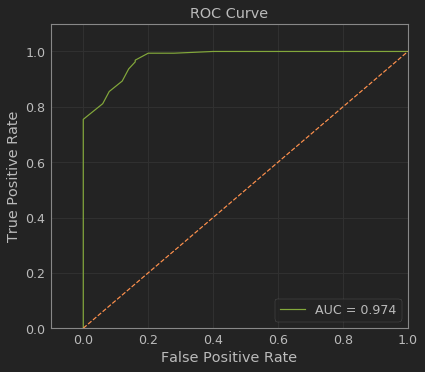

In [85]:
plot_ROC_AUC(false_positive_rate, true_positive_rate, roc_auc)

On remarque que l'AUC est excellent. Étant très près de 1, cela indique que le modèle classifie correctement la grande majorité des cours du jeu de données de test, et ce, avec un faible taux de faux positifs.

##  3. Effectuez une agglomération par k-means (k=2) et vérifiez si les classes PHY et PSY sont bien séparées par cette méthode (4 pts.).

2019.11.15. n.b. les questions 3 et 4 sont inversées par rapport à la version précédente.
Une approche non supervisée est adoptée ici, car nous n'utiliserons pas les "classes" PHY et PSY pour l'entraînement mais seulement pour le test.

Utilisez kmeans avec deux classes pour agglomérer les 521 cours PSY et PHY. Vérifiez si la classification correspond dans une bonne mesure aux deux ensembles de cours. Calculez la précision, le score F1 et finalement l'AUC avec la même méthode qu'à la question 2.

À noter qu'à cette étape, la classification donnée par le Knn peut être inattendue, mais l'AUC devrait être aux alentours de 0,75.


Nous allons aborder le problème avec l'ensemble du jeu de données déjà *preprocessed* et tenter d'obtenir l'AUC directement.

In [86]:
from sklearn.cluster import KMeans
# deterministic
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_data)
#kmeans = KMeans(n_clusters=2).fit(X_data)
labels = kmeans.labels_
sum(labels)

474

In [90]:
sum(labels) - n_positives

67

Déjà avec le nombre de cours compris dans le cluster 1, il est clair que l'approche non supervisée ne performera pas très bien. Avec 474 cours sur 521 dans le même cluster alors que l'on s'attendrait à 407 cours (le vrai nombre de cours de psychologie), on peut déjà affirmer que 67 cours ne seront pas correctement prédits.

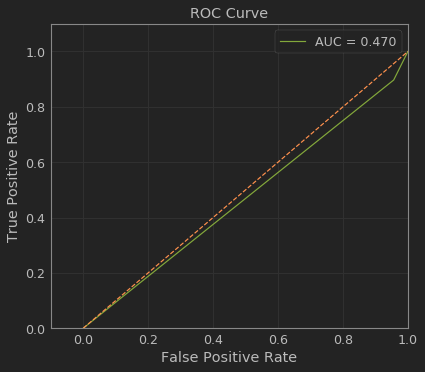

In [87]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_data, labels)
roc_auc = auc(false_positive_rate, true_positive_rate)
plot_ROC_AUC(false_positive_rate, true_positive_rate, roc_auc)

Puisque les labels ne contiennent que 2 valeurs possibles, soit 0 et 1, il n'est pas possible d'obtenir une belle courbe ROC avec plus de 3 points. C'est pourquoi nous allons plutôt utiliser une probabilité au cluster attribué en calculant la distance entre les points et les centres finaux.

De plus, on peut voir que l'AUC est sous 0.5, ce qui signifie qu'une attribution aléatoire serait meilleure que les clusters de kmeans. Cela n'a pas vraiment de sens: il faut également prendre en compte que kmeans ne connait pas les labels réels et attribue la valeur 1 et 0 à ses deux clusters de façon aléatoire, et que de meilleurs résultats pourraient donc être obtenus en inversant simplement les 1 et les 0 donnés par kmeans. Les calculs subséquents prendront en compte cette particularité en inversant les valeurs des clusters si l'AUC résultante est inférieure à 0.5.

Les fonctions suivantes permettent de:

    - calculer la distance entre deux points (deux cours *processed* résultant du preprocessing, TF-IDF et SVD)
    - calculer un score de probabilité selon les distances entre les deux centroïdes et le point, indiquant une "confiance" du modèle à attribuer un cluster à un point
    - transformer un array de labels donné par kmeans de sklearn ne contenant que des 1 et des 0 en un array de probabilité entre 0 et 1

In [41]:
def distance(center, point):
    return np.linalg.norm(center-point)

# This returns a score between 0 and 0.5 because we know the distance between the point's cluster and the cluster's center is less than the distance with the other cluster's center (by the nature of kmeans)
def score_proba(center, other_center, point):
    within_dist = distance(center, point)
    total_distances = within_dist + distance(other_center, point)
    return within_dist / total_distances

In [42]:
def labels_to_probas(centers, labels, points):
    probas = []
    for i in range(len(points)):
        point = points[i]
        label = labels[i]
        center = centers[label]
        other_center = centers[0]
        if label == 0:
            other_center = centers[1]
        proba = score_proba(center, other_center, point)
        if label == 1:
            proba = 1 - proba
        probas.append(proba)
    return probas

In [43]:
centers = kmeans.cluster_centers_
probas = labels_to_probas(centers, labels, X_data)

Les fonctions qui suivent permettent de:

    - inverser les prédictions (utilisé dans le cas où l'AUC est inférieur à 0.5)
    - exécuter le code nécessaire pour calculer l'AUC, le recalculer en ayant fait les modifications si celui-ci est inférieur à 0.5, puis de tracer un graphe
    

In [44]:
def reverse_predictions(predictions):
    new_predictions = []
    for pred in predictions:
        new_predictions.append(1 - pred)
    return new_predictions

In [45]:
def roc_curve_wrapper(actual, predictions):
    false_positive_rate, true_positive_rate, threshold = roc_curve(actual, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # if AUC is less than 0.5 just reverse all predictions
    if roc_auc < 0.5:
        predictions = reverse_predictions(predictions)
        false_positive_rate, true_positive_rate, threshold = roc_curve(actual, predictions)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        
    plot_ROC_AUC(false_positive_rate, true_positive_rate, roc_auc)    

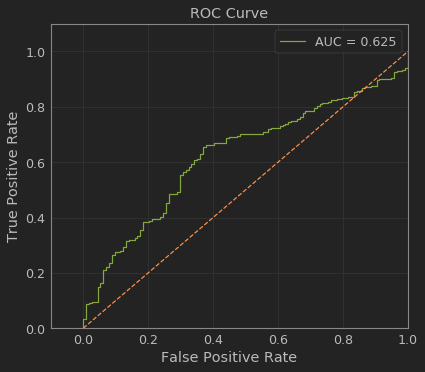

In [70]:
roc_curve_wrapper(y_data, probas)

L'AUC est maintenant bel et bien supérieur à 0.5 et on peut mieux observer son comportement en ayant maintenant des probabilités plutôt que simplement les labels données par kmeans. Cependant, la valeur de 0.625 est relativement basse.


Afin d'améliorer davantage les résultats, nous allons commencer le processing directement sur uniquement les cours PHY et PSY (TF-IDF et SVD) afin de réduire les mots et les dimensions à uniquement ce que comprend les descriptions de ces cours et non l'ensemble de tous les cours.

In [47]:
PHY_PSY_tokens = retrieve_PHY_PSY(tokens)

In [48]:
PHY_PSY_TFIDF = vectorizer.fit_transform(PHY_PSY_tokens)

In [49]:
PHY_PSY_TFIDF

<521x3176 sparse matrix of type '<class 'numpy.float64'>'
	with 22166 stored elements in Compressed Sparse Row format>

In [50]:
svd = TruncatedSVD(n_components=50, 
                   algorithm='randomized', 
                   n_iter=50
                  )
svd.fit(PHY_PSY_TFIDF)
PHY_PSY_SVD = svd.transform(PHY_PSY_TFIDF)

In [51]:
PHY_PSY_SVD.shape

(521, 50)

In [52]:
sum(svd.explained_variance_)

0.31069870541427197

In [93]:
def kmeans_wrapper(svd_data, deterministic=True):
    k_means = KMeans(n_clusters=2, random_state=0).fit(svd_data)
    if not deterministic:
        k_means = KMeans(n_clusters=2).fit(svd_data)
    k_labels = k_means.labels_
    k_centers = k_means.cluster_centers_
    k_probas = labels_to_probas(k_centers, k_labels, svd_data)
    #k_probas = k_labels
    return k_probas, k_labels


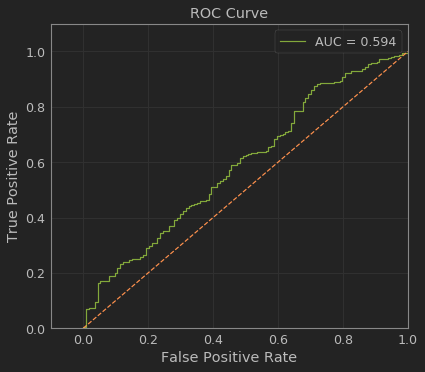

In [71]:
probas_PHY_PSY, labels_PHY_PSY = kmeans_wrapper(PHY_PSY_SVD)
roc_curve_wrapper(y_data, probas_PHY_PSY)

Les résultats ne se sont pas améliorés. Il semble que l'agglomération est meilleure en gardant l'information sur tous les cours qu'en ne gardant que l'information spécfique aux cours PHY et PSY.

Calculs de la précision et du score F1 pour les deux approches:

In [88]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print("precision for all data: " + str(precision_score(y_data, labels)))
print("F1 score for all data: " + str(f1_score(y_data, labels)))

precision for all data: 0.770042194092827
F1 score for all data: 0.8286038592508512


In [89]:
print("precision for only PHY and PSY courses: " + str(precision_score(y_data, labels_PHY_PSY)))
print("F1 score for only PHY and PSY courses: " + str(f1_score(y_data, labels_PHY_PSY)))

precision for only PHY and PSY courses: 0.7714884696016772
F1 score for only PHY and PSY courses: 0.832579185520362


Contrairement à l'AUC, la précision et le score F1 sont très semblables pour les deux approches. 

## 4. À partir de la validation croisée de la tâche de classification ci-dessus, déterminez le nombre de dimensions latentes optimal de SVD selon une approche dite wrapper (4 pts.).

Nous allons maintenant essayer d'améliorer les résultats en utilisant une réduction de dimension. Pour commencer, effectuez une réduction de dimensions à 50 facteurs latents et faites l'agglomération sur la matrice ainsi réduite. Puis refaites les calculs de la question 3. Et finalement, itérez sur différentes nombres de facteurs latents pour identifier la valeur optimale. Elle devrait se situer aux alentours de 20 et donner un AUC nettement supérieur à celui de la question 3.


In [95]:
def kmeans_AUC_for_n_dimensions(n_dimensions=50, use_all_data=True, kmeans_deterministic=True):
    svd = TruncatedSVD(n_components=n_dimensions, algorithm='randomized', n_iter=50)
    
    if use_all_data:
        svd.fit(IDF_data)
        svd_matrix_all = svd.transform(IDF_data)
        svd_matrix = retrieve_PHY_PSY(svd_matrix_all)
    else:
        svd.fit(PHY_PSY_TFIDF)
        svd_matrix = svd.transform(PHY_PSY_TFIDF)
    
    predictions, _ = kmeans_wrapper(svd_matrix, deterministic=kmeans_deterministic)
    
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_data, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    if roc_auc < 0.5:
        predictions = reverse_predictions(predictions)
        false_positive_rate, true_positive_rate, threshold = roc_curve(y_data, predictions)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        
    return roc_auc
    

In [57]:
# test 
kmeans_AUC_for_n_dimensions()

0.6251993620414673

In [58]:
aucs_all = []
dims_all = []
for n_dim in range(5, 200, 5):
    aucs_all.append(kmeans_AUC_for_n_dimensions(n_dimensions=n_dim))
    dims_all.append(n_dim)
    print("dimensions: " + str(n_dim), end='\r')

In [59]:
def plot_AUC_dim(auc_list, dims_list):
    plt.plot(dims_list, auc_list, 'g')
    plt.legend()
    plt.ylabel('AUC')
    plt.xlabel('Nombre de dimensions')
    plt.title('AUC selon le nombre de dimensions')
    plt.show()

No handles with labels found to put in legend.


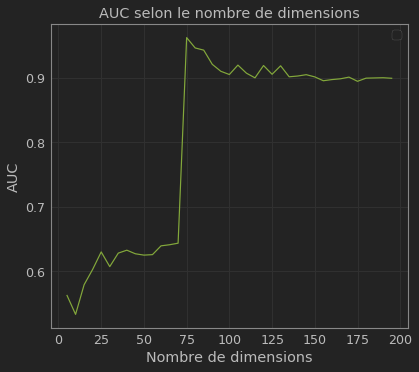

In [72]:
plot_AUC_dim(aucs_all, dims_all)

Le nombre de dimensions latentes optimal semble se situer autour de 75 dimensions.

Nous allons refaire l'expérience mais uniquement avec les données des cours PHY et PSY.

In [91]:
aucs = []
dims = []
for n_dim in range(5, 200, 5):
    aucs.append(kmeans_AUC_for_n_dimensions(n_dimensions=n_dim, use_all_data=False))
    dims.append(n_dim)
    print("dimensions: " + str(n_dim), end='\r')

No handles with labels found to put in legend.


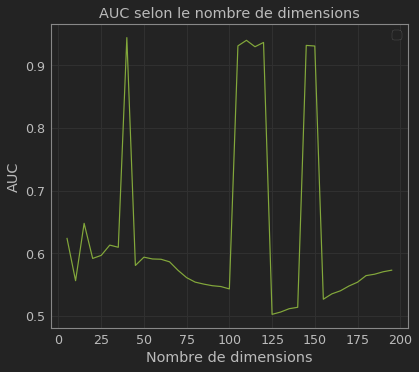

In [92]:
plot_AUC_dim(aucs, dims)

Contrairement à l'approche précédente, celle-ci donne des résultats douteux. On remarque une fenêtre très fine autour de 40 dimensions qui donnerait un AUC au dessus de 0.9. De plus, deux autres intervalles un peu plus grands semblent donner des résultats similaires entre 100 et 125 dimensions et entre environ 130 et 155 dimensions.

Nous allons refaire des calculs plus précis que la première fenêtre afin de s'assurer que ce n'est pas une exécution de kmeans exceptionnelle. Nous nous attardons sur ce pic plutôt que les autres car pouvoir utiliser que 40 dimensions indiquerait de meilleurs résultats que d'en nécessiter 100 et plus.

In [63]:
aucs = []
dims = []
for n_dim in range(30, 50):
    aucs.append(kmeans_AUC_for_n_dimensions(n_dimensions=n_dim, use_all_data=False))
    dims.append(n_dim)
    print("dimensions: " + str(n_dim), end='\r')

No handles with labels found to put in legend.


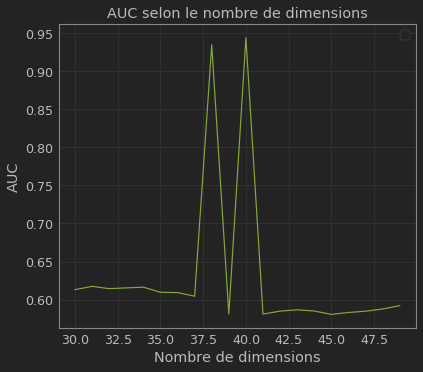

In [74]:
plot_AUC_dim(aucs, dims)

Avec les deux points de 38 et 40 dimensions latentes donnant des résultats similaires, il reste difficile d'affirmer que ce n'est pas des centroïdes de départ chanceux de kmeans. 

Nous allons refaire les calculs autour de 39 dimensions en utilisant kmeans de façon non-déterministe et comparer les résultats.

In [98]:
aucs = []
dims = []
for n_dim in range(30, 50):
    aucs.append(kmeans_AUC_for_n_dimensions(n_dimensions=n_dim, use_all_data=False, kmeans_deterministic=False))
    dims.append(n_dim)
    print("dimensions: " + str(n_dim), end='\r')

No handles with labels found to put in legend.


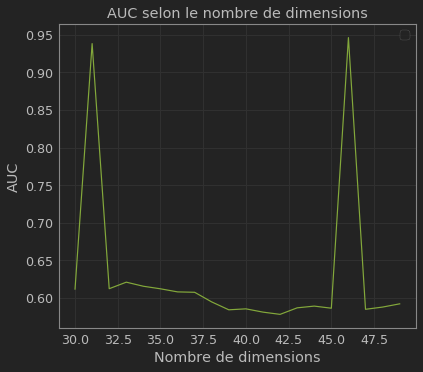

In [99]:
plot_AUC_dim(aucs, dims)

On remarque effectivement que pour ces exécutions, les résutlats sont forts différents. Cela indique qu'il aurait plutôt fallu exécuter kmeans plusieurs fois et prendre l'AUC moyen de plusieurs exécutions.

In [100]:
aucs = []
dims = []

n_execs = 5

for n_dim in range(30, 50):
    auc_mult = []
    for i in range(n_execs):
        auc_mult.append(kmeans_AUC_for_n_dimensions(n_dimensions=n_dim, use_all_data=False, kmeans_deterministic=False))
    auc_mean = sum(auc_mult)/n_execs
    
    aucs.append(auc_mean)
    dims.append(n_dim)
    print("dimensions: " + str(n_dim), end='\r')

No handles with labels found to put in legend.


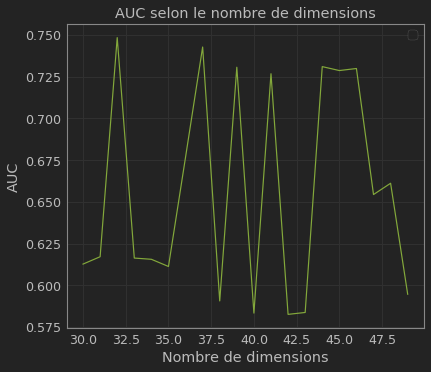

In [101]:
plot_AUC_dim(aucs, dims)

En conclusion, il est difficile de déterminer le bon nombre de dimensions latentes pour cette approche en particulier. Même en exécutant plusieurs fois kmeans, l'AUC varie énormément selon les centroïdes de départ.

Avec plus de temps / de meilleures ressources matérielles permettant d'accélérer les calculs, il serait intéressant de refaire l'expérience pour tous les points et en exécutant kmeans encore plus de fois pour chacun des points afin d'obtenir des résultats plus précis.

Par contre, l'autre approche en utilisant le jeu de données complet donne des résultats beaucoup plus facile à interpréter, avec 75 dimensions latentes qui semble être le nombre optimal.